# Using the butler to get data

Setup third party packages and some plotting configuration

In [1]:
%matplotlib inline
import os
from matplotlib import pylab as plt
plt.rcParams['figure.figsize'] = (13,8)
import numpy

Change to the directory where I did the demo

In [2]:
os.chdir('/global/cscratch1/sd/descdm/DC1/full_focalplane_undithered')

Set up some package to display, do our I/O and handle geometry operations

In [3]:
import lsst.afw.display as afw_display
import lsst.daf.persistence as daf_persistence
import lsst.afw.geom as afw_geom

Data are referred to by `dataId`s.  In essence, this is just a dictionary holding the information to locate a dataset uniquely.  We make two of these because there are two kinds of data we want to look at: calibrated exposures (or `calexp`s) and coadded images (or `deepCoadd`s).

For simulated data, we need to know the id for the exposure (visit), passband of the exposure (filter), and location in the focalplane (raft 2,2 and sensor 1,1) to get the calexp.

For the coadds we need to know the large area on the sky (tract), sub-region within the large area (patch) and bandpass of the coadd (filter).

In [4]:
calexpId = {'visit':1919421, 'filter':'r', 'raft':'2,2', 'sensor':'1,1'}
coaddId = {'patch':'5,5', 'tract':0, 'filter':'r'}

Datasets are accessed through the `Butler`.  A `Butler` can be constructed by simply passing a path to a valid butler data repository.  In cell 2 we switched to a directory containing such a butler repository, so we construct the `Butler` by just passing the current working directory.

In [5]:
butler = daf_persistence.Butler('.')

Now we retrieve the relevant datasets into memory.  There are four such datasets: a calibrated exposure (`calexp`) and the catalog of detections on that exposure (`src`), a deep stack of images (`deepCoadd`) and the catalog of detections on the coadd (`deepCoadd_meas`).  These are retrieved by calling the `get` method of the `Butler` and giving it the dataset name (in parens in the preceding sentence) and the data id for each.

In [6]:
calexp = butler.get('calexp', dataId=calexpId)
calexp_src = butler.get('src', dataId=calexpId)
coadd = butler.get('deepCoadd', dataId=coaddId)
coadd_src = butler.get('deepCoadd_meas', dataId=coaddId)

Now set up the display environment.  At this point you need DS9 running or for it to be on your PATH.  We will use separate frames for the `calexp` and the `coadd` so we need two different displays.  Then the `mtv` command can be used to display the exposures.

In [12]:
calexp_display = afw_display.getDisplay(frame=1)
coadd_display = afw_display.getDisplay(frame=2)
calexp_display.mtv(calexp)
coadd_display.mtv(coadd)

We have a catalog, but what is in the catalog?  You can print the schema and doc string to get a sense of what the columns are.  Below are the non-flag fields.

In [8]:
for field in calexp_src.schema:
    name = field.getField().getName()
    if 'flag' not in name:
        print(name+':', field.getField().getDoc())

id: unique ID
coord_ra: position in ra/dec
coord_dec: position in ra/dec
parent: unique ID of parent source
calib_detected: Source was detected as an icSource
calib_psfCandidate: Flag set if the source was a candidate for PSF determination, as determined by the star selector.
calib_psfUsed: Flag set if the source was actually used for PSF determination, as determined by the
calib_psfReserved: Flag set if the source was selected as a PSF candidate, but was reserved from the PSF fitting.
deblend_nChild: Number of children this object has (defaults to 0)
deblend_deblendedAsPsf: Deblender thought this source looked like a PSF
deblend_psfCenter_x: If deblended-as-psf, the PSF centroid
deblend_psfCenter_y: If deblended-as-psf, the PSF centroid
deblend_psfFlux: If deblended-as-psf, the PSF flux
deblend_tooManyPeaks: Source had too many peaks; only the brightest were included
deblend_parentTooBig: Parent footprint covered too many pixels
deblend_masked: Parent footprint was predominantly maske

And the flag fields:

In [9]:
for field in calexp_src.schema:
    name = field.getField().getName()
    if 'flag' in name:
        print(name+':', field.getField().getDoc())

flags_negative: set if source was detected as significantly negative
base_GaussianCentroid_flag: general failure flag, set if anything went wrong
base_GaussianCentroid_flag_noPeak: Fitted Centroid has a negative peak
base_GaussianCentroid_flag_resetToPeak: set if CentroidChecker reset the centroid
base_NaiveCentroid_flag: general failure flag, set if anything went wrong
base_NaiveCentroid_flag_noCounts: Object to be centroided has no counts
base_NaiveCentroid_flag_edge: Object too close to edge
base_NaiveCentroid_flag_resetToPeak: set if CentroidChecker reset the centroid
base_SdssCentroid_flag: general failure flag, set if anything went wrong
base_SdssCentroid_flag_edge: Object too close to edge
base_SdssCentroid_flag_noSecondDerivative: Vanishing second derivative
base_SdssCentroid_flag_almostNoSecondDerivative: Almost vanishing second derivative
base_SdssCentroid_flag_notAtMaximum: Object is not at a maximum
base_SdssCentroid_flag_resetToPeak: set if CentroidChecker reset the centro

Now we can plot the above catalog on top of the exposures we have displayed in DS9.

In [10]:
with calexp_display.Buffering():
    for source in calexp_src:
        calexp_display.dot('o', source.getX(), source.getY())
with coadd_display.Buffering():
    for source in coadd_src:
        coadd_display.dot('x', source.getX(), source.getY())

Convert flux into magnitude using the calibration object from the deep coadd.

In [10]:
modelFlux = coadd_src.getModelFlux()
modelFlux_flag = coadd_src.get('modelfit_CModel_flag')
psfFlux = coadd_src.getPsfFlux()
psfFlux_flag = coadd_src.get('base_PsfFlux_flag')
coadd_calib = coadd.getCalib()
modelMags = []
psfMags = []
for mflux, pflux, mflag, pflag in zip(modelFlux, psfFlux, modelFlux_flag, psfFlux_flag):
    if mflux > 0 and pflux > 0 and not (mflag or pflag):
        modelMags.append(coadd_calib.getMagnitude(mflux))
        psfMags.append(coadd_calib.getMagnitude(pflux))
modelMags = numpy.array(modelMags)
psfMags = numpy.array(psfMags)

Now plot.  We are plotting a proxy for extendedness in the PSF magnitude minus the model magnitude.  For pointsources, the two should be equivalent but not for extended sources.  The tick up in the stellar locus to the left is due to saturation.

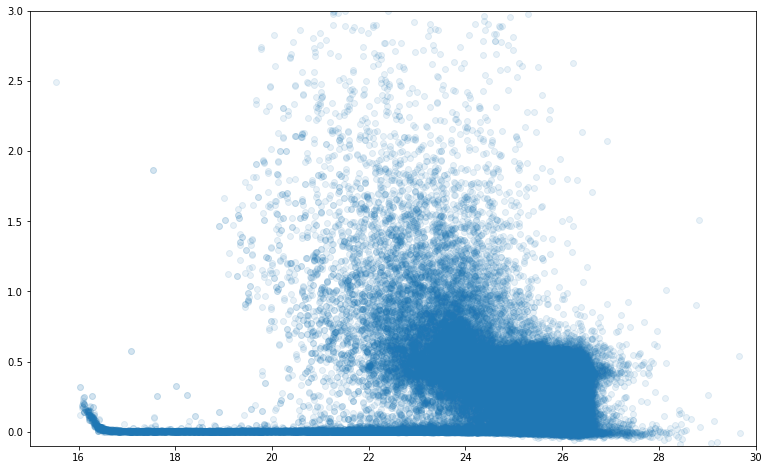

In [11]:
plt.scatter(psfMags, psfMags-modelMags, alpha=.1)
plt.xlim(15., 30)
plt.ylim(-0.1, 3)
plt.show()